# 자연어 처리

- 단어 표현
  - 형태소 분석: 토큰화 + 품사부착 (태깅)
  - One Hot
  - CBOW
  - TF - IDF
  - Skip Gram

- 문장 표현

  - Text to Sequence
  - Padding
- 텍스트 마이닝

  - 기계 학습
  - 신경망 알고리즘 활용 기법
    - RNN, LSTM, GRU, ...
   
- 자연어 이해

# 자연어 생성

## Sequence to Sequence (Seq2Sqe)

- 자연어 처리에서 기존의 일반적인 판별모델(NLU, RNN, LSTM)은 문장 내 단어들을 각 Node들이 처리하여 하느이 결과 계산
- 입력된 Sequence를 이용해, 하나의 나열된 Sequence를 출력하는 구조를 만들어 학습을 수행
- 기계 번역, 챗봇, 문장요약, STT

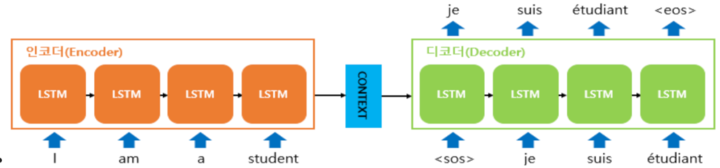

- Seq2Seq는 크게 3가지 파트로 구성(두개의 RNN구조)
  - Encoder
    - Input Sequence를 (입력문장) 받아 문장을 특정 Vector로 변환하는 구조
    - 입력 값의 정보를 각 Node가 가지고 처리
    - Encoder에서 처리된 정보는 Context Vector로 전달
  - Decoder
    - Output Sequence 를 학습하여, Input Sequence에 해당하는 적절한 OutPut출력
  - Context Vector
    - Encoder에 의해 하나의 문장정보가 처리된 Matrix
    - Decoder가 Context Vector에 날아온 정보와 답변을 학습하여, 새로운 Input Seqence가 들어올 때, Decoder는 그에 맞는 문장을 출력
- 작동 순서
  1. 입력 문장(Input Sequence)를 단어 토큰화를 통해, 단어 단위로 쪼갬
  2. 각 토큰을 문장 순서대로 RNN Model에 입력(Encoder)
  3. Encoder에서 마지막 Node에 계산된 값을 Context Vector로 변환한 뒤, Decoder로 전달
  4. Decoder는 앞서 받은 Context Vector를 첫번째 Node에 넣어 처리
  5. Decoder는 초기 입력문장의 시작을 의미하는 심볼인 SOS(Start of Sequence)값을 넣어 순차적으로 처리
  6. 이후 Decoder는 문장을 이어받으며, 다음에 등장할 확률이 높은 단어를 예측
  7. EOS(End of Sequence)토큰이 등장하거나, 문장이 최대 길이까지 위의 과정을 반복하여 단어를 학습, 예측
  8. 학습은 SOS에서 시작해 EOS가 나올 때 까지 학습이 수행, 예측된 값은 Output Sequence출력

In [1]:
# 텍스트 파일 호출
with open('kor.txt', encoding = 'UTF-8') as file:
    text1 = file.read().split('\n')

In [2]:
text1[-10:]

['She asked him to help her father clean the garage, but he said that he was too busy to help.\t그녀는 그녀의 아버지가 차고 청소 하는 것을 도와 주라고 그에게 얘기 했지만 그는 너무 바빠서 못 도와 준대.\tCC-BY 2.0 (France) Attribution: tatoeba.org #886975 (CK) & #3675039 (JangSungHyuk)',
 'If your father asks your mother a question in French, does she answer in French or in English?\t너의 아버지가 어머니에게 만약 프랑스어로 질문을 하면 그녀는 프랑스어로 대답하니 아니면 영어로 대답하니?\tCC-BY 2.0 (France) Attribution: tatoeba.org #4806956 (CK) & #9689557 (ST_Young)',
 'Tom always cried when his sister took away his toys, and for that very reason she loved to do so.\t톰은 누나가 자기 장난감을 빼앗아 갔을 때마다 울음을 터뜨렸고, 누나는 바로 그런 이유로 그런 짓을 곧잘 해댔다.\tCC-BY 2.0 (France) Attribution: tatoeba.org #8403991 (CK) & #8404074 (Eunhee)',
 'Science fiction has undoubtedly been the inspiration for many of the technologies that exist today.\t공상 과학은 의심의 여지 없이 오늘날 존재하는 많은 기술에 영감을 주었어.\tCC-BY 2.0 (France) Attribution: tatoeba.org #6067784 (mailohilohi) & #8363688 (Eunhee)',
 "I started a new blog. I'll do my 

In [3]:
# 입력 받을 영어 데이터와 학습시킬 한국어 데이터를 처리할 리스트를 선언
input_text = [] #영어 문장 리스트
target_text = [] # 한국어 문장 리스트

# 영어, 한국어 단어가 숫자로 변환된 정보를 처리하는 Set 구조를 선언
# Text가 Sequence로 표현되기 위해(단어 -> 숫자) 각 단어나 문자의 고유값을 중복 없이 자료구조로 정리
input_char_list = set()
target_char_list = set()

for line in text1:
    # Decoder에서 처리될 한국어 문장의 경우
    # <SOS>와 <EOS>를 부착하여 자료구조에 추가
    # 처리 단계에서 오류 방지를 위한 예외 처리
    try:
        # unpacking: 특정 tuple에 있는 값을 데이터 개수에 맞춰 선언하면 각 변수에 자료가 선언
        eng, kor, ect = line.split('\t')
        # 한국어 문장의 경우 SOS와 EOS 태그를 부착
        kor = '\t' + kor + '\n'
        input_text.append(eng)
        target_text.append(kor)
    except Exception as e:
        print(e)
        continue
    # 분할된 모든 문장에 대해 각 고유 단어를 자료구조에 선언
    for x in eng:
        input_char_list.add(x)
    for x2 in kor:
        target_char_list.add(x2)

not enough values to unpack (expected 3, got 1)


In [4]:
input_characters = sorted(input_char_list)
target_characters = sorted(target_char_list)

In [5]:
# 각 철자에 숫자를 부여 (Corpus)
input_token_index = {x: idx for idx, x in enumerate(input_characters)}
target_token_index = {x: idx for idx, x in enumerate(target_characters)}

In [6]:
# padding을 수행함과 동시에 text -> matrix로 변환
# 전체 문장 중, 가장 길이가 긴 문장의 단어 수를 먼저 확인
max_encoder_seq_length = max([len(x) for x in input_text])
max_decoder_seq_length = max([len(x) for x in target_text])

In [7]:
print(max_decoder_seq_length, max_encoder_seq_length)

298 537


In [8]:
import numpy as np

# matrix 구성
encoder_input_data = np.zeros(
    (len(input_text), max_encoder_seq_length, len(input_characters)), dtype='float32'
)
decoder_input_data = np.zeros(
    (len(input_text), max_decoder_seq_length, len(target_characters)), dtype='float32'
)

# 출력 한국어 문장이 담길 Matrix를 구성(Decoder 출력)
decoder_target_data = np.zeros(
    (len(input_text), max_decoder_seq_length, len(target_characters)), dtype='float32'
)

In [9]:
encoder_input_data.shape

(5890, 537, 74)

In [10]:
# 구성된 matrix에 각 단어에 매칭되는 숫자를 입력
# 영어 문장과 한국어 문장을 각각 가져와 동시에 숫자 matrix를 구성
for idx, (eng, kor) in enumerate(zip(input_text, target_text)):
    # 영어 문장에 대해 해당 단어를 숫자 형태로 변환
    for k, char in enumerate(eng):
        encoder_input_data[idx, k, input_token_index[char]] = 1 # idx: 문장 줄, k: 문장 내 글자 위치, char: 해당 글자
    # 한국어 문장에 대해 해당 단어를 숫자 형태로 변환
    for j, char in enumerate(kor):
        decoder_input_data[idx, j, target_token_index[char]] = 1
        # SOS 데이터에 대해 처리
        if j > 0:
            decoder_input_data[idx, j - 1, target_token_index[char]] = 1

In [11]:
encoder_input_data.sum()

161229.0

In [12]:
# encoder와 decoder구조를 구성
batch_size = 32 # 128이상 사용하면 좋음
epochs = 20 # 신경망 내 weight를 업데이터 하기 위해 반복 횟수(500회 이상 권장)
node_num = 64 # 각 layer 내 node의 수로 1024이상 권장

In [13]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# encoder 구성
# 영어 문장이 들어가 lstm모델에 의해 학습이 수행 되도록 구성
encoder_input = Input(shape=(None, len(input_characters))) # 영어 문장이 들어오는 layer
encoder = LSTM(node_num, return_state = True)

# encoder lstm모델에 input data를 입력하여 출력 계산 -> context vector
# encoder_output: lstm모델에 의해 최종적으로 계산된 값
# state_h: 마지막 layer에서 출력된 node의 정보
# state_c: 마지막 layer에서 출력된 Cell state(RNN 모혀을 보완하기 위해 seq의 장기 정보를 저장하는 Cell)의 정보
encoder_output, state_h, state_c = encoder(encoder_input)
# 인코더가 입력 seq를 처리한 후 얻은 정보(node 정보, cell state정보)를 decoder 전달
# context vector
encoder_state = [state_h, state_c]

In [14]:
# Decoder 구성
# 앞서 encoder에서 처리된 정보를 받아, 한국어 문장이 들어가 LSTM모델에 의해 학습이 수행되도록 구성
decoder_input = Input(shape = (None, len(target_characters)))
decoder = LSTM(node_num, return_sequences=True, return_state=True)
# return_sequences = True

# 앞서 처리된 encoder state정보를 바탕으로 decoder의 초기 상태를 설정
decoder_output, deco_h, deco_c = decoder(decoder_input, initial_state = encoder_state)

# soft max 함수에 의해 출력값을 계산
decoder_dense = Dense(len(target_characters), activation='softmax')
decoder_output = decoder_dense(decoder_output)

In [15]:
# Seq2Seq 구성(NLU 과정, 입력문장(영어문장), 타겟문장(한국어문장)을 컴퓨터가 이해할 수 있게 학습)
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs = epochs, validation_split = 0.2)

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 91s 553ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 60s 404ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 64s 435ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 76s 510ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 67s 440ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 70s 470ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 66s 446ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 75s 502ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 71s 476ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 63s 425ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/20
148/148 ━━━━━━━━━

In [16]:
# nlu이후의 nlg파트를 구성
# 학습 과정에서 구성한 인코더의 입력과 상태를 기반으로 새로 언어를 생성하는 모델을 구성

encoder_model = Model(encoder_input, encoder_state)
# 디코더의 lstm 레이어에 전달 될 초기 상태를 정의
decoder_state_input_h = Input(shape=(node_num, )) # decoder node 정보의 초기값
decoder_state_input_c = Input(shape=(node_num, )) # cell state 초기값
# 디코더의 node와 cell state의 초기정보를 구성
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
#구성된 input 정보를 이용하여, decoder later를 구성
decoder_output, state_h, state_c = decoder(decoder_input, initial_state = decoder_state_inputs)

In [18]:
# 다음 step으로 전달 될 상태를 지정
decoder_state = [state_h, state_c]
# soft max 함수를 이용해 출력 계산
decoder_outputs = decoder_dense(decoder_output)
# 다음단계의 단어(토큰)을 예측하고, 다음 문장을 생성하기 위한 새로운 상태를 구성
decoder_model = Model([decoder_input] + decoder_state_inputs, [decoder_outputs] + decoder_state)

In [19]:
# 디코더에 의해 계산된 숫자 결과를 다시 문자로 변환하는 작업을 수행
# 숫자 -> 문자로 변환하는 사전을 구성
reverse_input_char_index = dict([(i, char) for char, i in input_token_index.items()])
reverse_target_char_index = dict([(i, char) for char, i in target_token_index.items()])


In [23]:
# 입력 문장이 들어왔을 때, 해당 문장을 번역하는 함수를 구성
def decode_sequence(input_seq):
    # 입력 받은 Sequence를 Encoder에 집어 넣어 Context Vector로 변환
    # verbose=0 : 학습/예측의 진행상황을 생략
    state_value = encoder_model.predict(input_seq, verbose=0)
    # Decoder의 초기 Sequence를 생성
    # 모든 토큰값에 대해 0으로 채워진 Array를 구성
    target_seq = np.zeros( (1, 1, len(target_characters)) )
    # 시작 토큰의 위치(SOS)를 1로 설정하여, Decoder가 예측을 시작할 부분을 지정
    target_seq[0, 0, target_token_index['\t']] = 1
    # Decoder 실시
    # Decoder의 종료조건 :
        # 1. <EOS> 토큰이 생성되면, 생성모델의 작동을 중지
        # 2. 사용자가 지정한 문장의 길이를 벗어나는 경우에도 종료
    # 종료조건을 판별하는 변수
    stop_cond = True
    # 생성될 문자를 담아줄 변수를 생성
    decoder_sentence = ''
    # 위의 종료조건이 수행 될 때 까지 반복하여 단어를 생성
    while stop_cond:
        # 디코더의 Layer정보를 이용하여 Output Token을 출력
        output_token, h, c = decoder_model.predict( [target_seq]+ state_value,  verbose=0)
        # 가장 확률이 높게 계산된 숫자값을 확인
        sampled_token_index = np.argmax(output_token[0,-1, :])
        # 앞서 찾은 Index를 문자로 변환
        sampled_char = reverse_target_char_index[sampled_token_index]
        # 하나씩 생성된 철자를 문장으로 이어 붙이기
        decoder_sentence += sampled_char
        # 종료 조건
        if (sampled_char=='\n' or len(decoder_sentence)>= max_decoder_seq_length):
            stop_cond = False
        # 종료가 되지 않았을 때, 다음 단어를 예측하기 위한 일부 변수의 초기화
        target_seq = np.zeros((1,1,len(target_characters)))
        target_seq[0,0, sampled_token_index] = 1
        state_value = [h, c]
    # 종료조건에 의해 반복문이 멈추면, 생성된 문장을 출력
    return decoder_sentence

In [25]:
# 기존 데이터에 있는 영어 문장을 이용해, 번역 결과를 확인
for seq_index in range(50, 55):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    result = decode_sequence(input_seq)
    print('입력 문장 : ', input_text[seq_index])
    print('출력 문장 : ', result)

입력 문장 :  Be calm.
출력 문장 :  부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부
입력 문장 :  Be fair.
출력 문장 :  부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부
입력 문장 :  Beat it.
출력 문장 :  부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부부
입력 문장 :  Call us.
출력 문

- Seq2Seq 모델의 단점:
  1. 긴 Sequence에 대해 RNN계열 모델의 기울기 소실, 폭주 문제가 발생
  2. Context Vector의 크기가 고정되어 있어 정보 손실이 발생

# Attention Mechanism

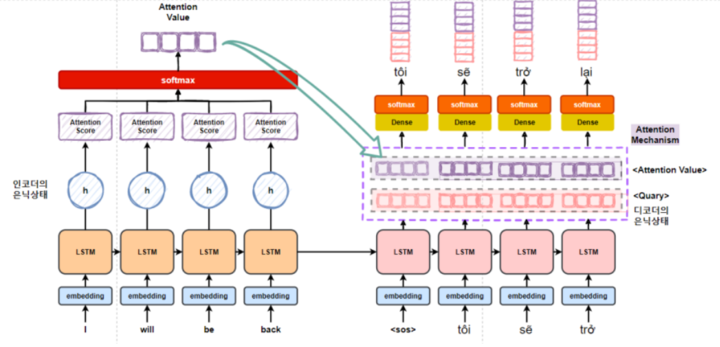

- 입력 문장의 각 요소에 대해 가중치를 계산한 뒤, 중요한 요소에 높은 가중치를 부여하고, 낮은 곳은 패널티를 부여해 특정 부분을 강조
- decoder에서 출력 단어를 예측할 때, 매 시점마다, encoder의 전체 입력문장을 다시 한번 강조

- 원리
  - 모든 단어 쌍에 대한 key-value형태로 묶어 유사도 분석
  - 각 단어쌍의 유사도를 이용하여 attension score를 계산
  - attension score: decoder에서 특정 t 시점에 단어를 예측하기 위해, 인코더의 모든 node 상태 각각이 decoder의 현 시점과 얼마나 유사한지 비교
- 구성 요소:
  1. query(질의)
     - 현재 출력 시점에서 모델이 '어떤 정보가 필요한지'를 표현
     - 일반적으로 디코더의 현재 state값으로 표현
  2. key
     - 입력 문장의 각 요소를 '검색 가능하도록' 만드는 표현
     - 입력 문장의 state를 표현
  3. value
     - 입력 문장의 실제 정보
     - key 동일한 차원을 갖는 정보

In [26]:
import pickle
from keras.layers import Attention

In [27]:
# 영어 문장과 한국어 문장을 숫자로 변환한 결과
load_seq_data = pickle.load(open('data/eng_to_kor.sav', 'rb'))
encoder_input_data, decoder_input_data, decoder_target_data = load_seq_data

# 단어 토큰에 대한 사전 데이터
input_token_index, target_token_index = pickle.load(open('token_index.sav', 'rb'))

In [28]:
num_encoder_tokens = len(input_token_index)
num_decoder_tokens = len(target_token_index)
print(num_encoder_tokens)
print(num_decoder_tokens)

72
961


In [29]:
batch_size = 128
epochs = 30
node_num = 128
max_decoder_seq_length = 40
max_encoder_seq_length = 40

In [31]:
# encoder와 decoder를 정의
encoder_input = Input(shape = (None, num_encoder_tokens))
# attension score를 계산하기 위해, Encoder에서도 각 node의 결과를 출력
# return_sequences = True
encoder_lstm = LSTM(node_num, return_state=True, return_sequences=True)
encoder_output, state_h, state_c = encoder_lstm(encoder_input)
encoder_state = [state_h, state_c] # context vector

decoder_input = Input(shape = (None, num_decoder_tokens))
decoder_lstm = LSTM(node_num, return_state=True, return_sequences=True)
decoder_output, d_h, d_c = decoder_lstm(decoder_input, initial_state = encoder_state)

# attention layer를 추가
attention = Attention()
attention_output = attention([decoder_output, encoder_output])
# 최종 출력
decoder_dense = Dense(num_decoder_tokens, activation = 'softmax')
decoder_outputs = decoder_dense(attention_output)

In [33]:
# Encoder와 Decoder의 input data 학습 수행
model = Model([encoder_input, decoder_input], decoder_outputs)
#학습 실시
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split=0.2)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 2.2177 - val_loss: 2.4110
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 1.6171 - val_loss: 2.4156
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 1.6293 - val_loss: 2.4175
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 1.6287 - val_loss: 2.4152
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 1.6211 - val_loss: 2.4125
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 1.6226 - val_loss: 2.4154
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 1.6265 - val_loss: 2.4128
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 1.6398 - val_loss: 2.4136
Epoch 9/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 1.6136 - val_loss: 2.4117
Epoch 10/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 1.6254 - val_loss: 2.4127
Epoch 11/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - loss: 1.6238 - val_loss: 2.4104
Epoch 12/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step

In [34]:
# 자연어 생성
encoder_model = Model(encoder_input, encoder_state)
decoder_state_input_h = Input(shape = (node_num, ))
decoder_state_input_c = Input(shape = (node_num, ))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_input, initial_state = decoder_state_inputs)
decoder_state = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_input] + decoder_state_inputs, [decoder_outputs] + decoder_state)

In [35]:
# 출력 결과를 문자로 변환
reverse_input_char_index  = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [36]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1,1,num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1
    stop_condition = True
    decoded_sentence = ''
    while stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value ,
                                                    verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        if (sampled_char == '\n') or (len(decoded_sentence)>= max_decoder_seq_length):
            stop_condition = False
        target_seq = np.zeros((1,1,num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1
        states_value = [h, c]
    return decoded_sentence

In [37]:
# 입력문장이 String 형태로 들어오면 해당 문장을 Encoding 하여,
# 모델에 들어갈 수 있는 형태로 변환
def preprocess_input_sequence(sentence):
    # 새로운 문장이 들어갈 공간을 형성
    input_seq = np.zeros((1, max_encoder_seq_length, num_encoder_tokens),
                        dtype='float32')
    # 각 문장에 있는 단어를 Encoding을 통해 Matrix에 입력
    for k , char in enumerate(sentence):
        input_seq[0, k, input_token_index[char]] = 1
    return input_seq

# 문장을 입력받아 번역을 수행하는 함수를 구성
def translate(input_sequence):
    input_seq = preprocess_input_sequence(input_sequence)
    # 번역 수행
    decoded_sentenece = decode_sequence(input_seq)
    return decoded_sentenece


In [38]:
translate('Hi')

'                                        '

In [39]:
translate('Go')

'                                        '